In [1]:
#!pip3 install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import warnings
import os

# Problem Statement - Credit Risk Modelling

### To predict which customers to give out a loan to based on the chances of default.

### Asset for bbanks - loans, credit cards
### Liabilities for banks - CASA, Term Deposits

In [5]:
#OSP =Outstanding Principal 
#DPD - Days past Due
#PAR - Porfolio at Risk  - OSP when DPD >0
#NPA - DPD>90days - Loan Account becomes NPA
#Non deliquent account - DPD = 0 
#DPD -0 to 30 - SMA1 (Standard Monitoring Account), 30-60 - SMA2 , 60-90 - SMA3 
#DPD > 180 - written off - bank writes this off because NPA figure for banks imporve, their loan portfolio will look better, market sentiment positive



In [6]:
#when investing in bank stocks one looks at GNPA and NNPA
#Gross NPA - 3 to 5 % - OSP default - assess bank quality 
#Net NPA - 0.01 to 0.06 - Provisioning amount is subtracted (amount bank kept aside)



In [7]:
#read in the data 
cust_df = pd.read_excel('case_study2.xlsx') #this is internal bank dataset

In [8]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PROSPECTID                    51336 non-null  int64  
 1   time_since_recent_payment     51336 non-null  int64  
 2   time_since_first_deliquency   51336 non-null  int64  
 3   time_since_recent_deliquency  51336 non-null  int64  
 4   num_times_delinquent          51336 non-null  int64  
 5   max_delinquency_level         51336 non-null  int64  
 6   max_recent_level_of_deliq     51336 non-null  int64  
 7   num_deliq_6mts                51336 non-null  int64  
 8   num_deliq_12mts               51336 non-null  int64  
 9   num_deliq_6_12mts             51336 non-null  int64  
 10  max_deliq_6mts                51336 non-null  int64  
 11  max_deliq_12mts               51336 non-null  int64  
 12  num_times_30p_dpd             51336 non-null  int64  
 13  n


**Approved_flag** is the target  
- **P** are priority levels: P1 > P2 > P3 > P4
- 350-900 credit score by **CIBIL**
- Loan is also called a **trade line**  
- **Secured loans** are given using collateral

### Key Terms:
- **Total_TL**: Total trade lines/accounts in Bureau.
- **Tot_Closed_TL**: Total closed trade lines/accounts.
- **Tot_Active_TL**: Total active accounts.
- **Total_TL_opened_L6M**: Total accounts opened in the last 6 months.
- **Tot_TL_closed_L6M**: Total accounts closed in the last 6 months.
- **pct_tl_open_L6M**: Percent accounts opened in the last 6 months.
- **pct_tl_closed_L6M**: Percent accounts closed in the last 6 months.
- **pct_active_tl**: Percent active accounts.
- **pct_closed_tl**: Percent closed accounts.
- **Total_TL_opened_L12M**: Total accounts opened in the last 12 months.
- **Tot_TL_closed_L12M**: Total accounts closed in the last 12 months.
- **pct_tl_open_L12M**: Percent accounts opened in the last 12 months.
- **pct_tl_closed_L12M**: Percent accounts closed in the last 12 months.
- **Tot_Missed_Pmnt**: Total missed payments.
- **Auto_TL**: Count of automobile accounts.
- **CC_TL**: Count of credit card accounts.
- **Consumer_TL**: Count of consumer goods accounts.
- **Gold_TL**: Count of gold loan accounts.
- **Home_TL**: Count of housing loan accounts.
- **PL_TL**: Count of personal loan accounts.
- **Secured_TL**: Count of secured accounts.
- **Unsecured_TL**: Count of unsecured accounts.
- **Other_TL**: Count of other accounts.
- **Age_Oldest_TL**: Age of the oldest opened account.
- **Age_Newest_TL**: Age of the newest opened account.


In [10]:
bur_df = pd.read_excel('case_study1.xlsx') #cibil external dataset
bur_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PROSPECTID            51336 non-null  int64  
 1   Total_TL              51336 non-null  int64  
 2   Tot_Closed_TL         51336 non-null  int64  
 3   Tot_Active_TL         51336 non-null  int64  
 4   Total_TL_opened_L6M   51336 non-null  int64  
 5   Tot_TL_closed_L6M     51336 non-null  int64  
 6   pct_tl_open_L6M       51336 non-null  float64
 7   pct_tl_closed_L6M     51336 non-null  float64
 8   pct_active_tl         51336 non-null  float64
 9   pct_closed_tl         51336 non-null  float64
 10  Total_TL_opened_L12M  51336 non-null  int64  
 11  Tot_TL_closed_L12M    51336 non-null  int64  
 12  pct_tl_open_L12M      51336 non-null  float64
 13  pct_tl_closed_L12M    51336 non-null  float64
 14  Tot_Missed_Pmnt       51336 non-null  int64  
 15  Auto_TL            


### Cibil:
- time_since_recent_payment: Time since recent Payment made.

### External:
- time_since_first_delinquency: Time since first Delinquency (missed payment).
- time_since_recent_delinquency: Time Since recent Delinquency.
- num_times_delinquent: Number of times delinquent.
- max_delinquency_level: Maximum delinquency level.
- max_recent_level_of_delinq: Maximum recent level of delinquency.
- num_deliq_6mts: Number of times delinquent in the last 6 months.
- num_deliq_12mts: Number of times delinquent in the last 12 months.
- num_deliq_6_12mts: Number of times delinquent between last 6 months and last 12 months.
- max_deliq_6mts: Maximum delinquency level in the last 6 months.
- max_deliq_12mts: Maximum delinquency level in the last 12 months.
- num_times_30p_dpd: Number of times 30+ dpd.
- num_times_60p_dpd: Number of times 60+ dpd.
- num_std: Number of standard Payments.
- num_std_6mts: Number of standard Payments in the last 6 months.
- num_std_12mts: Number of standard Payments in the last 12 months.
- num_sub: Number of substandard payments - not making full payments.
- num_sub_6mts: Number of substandard payments in the last 6 months.
- num_sub_12mts: Number of substandard payments in the last 12 months.
- num_dbt: Number of doubtful payments.
- num_dbt_6mts: Number of doubtful payments in the last 6 months.
- num_dbt_12mts: Number of doubtful payments in the last 12 months.
- num_lss: Number of loss accounts.
- num_lss_6mts: Number of loss accounts in the last 6 months.
- num_lss_12mts: Number of loss accounts in the last 12 months.
- recent_level_of_delinq: Recent level of delinquency.
- tot_enq: Total enquiries.
- CC_enq: Credit card enquiries.
- CC_enq_L6m: Credit card enquiries in the last 6 months.
- CC_enq_L12m: Credit card enquiries in the last 12 months.
- PL_enq: Personal Loan enquiries.
- PL_enq_L6m: Personal Loan enquiries in the last 6 months.
- PL_enq_L12m: Personal Loan enquiries in the last 12 months.
- time_since_recent_enq: Time since recent enquiry.
- enq_L12m: Enquiries in the last 12 months.
- enq_L6m: Enquiries in the last 6 months.
- enq_L3m: Enquiries in the last 3 months.
- MARITALSTATUS: Marital Status.
- EDUCATION: Education level.
- AGE: Age.
- GENDER: Gender.
- NETMONTHLYINCOME: Net monthly income.
- Time_With_Curr_Empr: Time with the current Employer.
- pct_of_active_TLs_ever: Percent active accounts ever.
- pct_opened_TLs_L6m_of_L12m: Percent accounts opened in the last 6 months to last 12 months.
- pct_currentBal_all_TL: Percent current balance of all accounts.
- CC_utilization: Credit card utilization.
- CC_Flag: Credit card Flag.
- PL_utilization: Personal Loan utilization.
- PL_Flag: Personal Loan Flag.
- pct_PL_enq_L6m_of_L12m: Percent enquiries PL in the last 6 months to last 12 months.
- pct_CC_enq_L6m_of_L12m: Percent enquiries CC in the last 6 months to last 12 months.
- pct_PL_enq_L6m_of_ever: Percent enquiries PL in the last 6 months to ever.
- pct_CC_enq_L6m_of_ever: Percent enquiries CC in the last 6 months to ever.
- max_unsec_exposure_inPct: Maximum unsecured exposure in percent.
- HL_Flag: Housing Loan Flag.
- GL_Flag: Gold Loan Flag.
- last_prod_enq2: Latest product enquired for.
- first_prod_enq2: First product enquired for.
- Credit_Score: Applicant's credit score.
- Approved_Flag: Priority levels.



## in India , less credit utilization is better, maxing out bad 

In [13]:
#making copies 
df1 = cust_df.copy()
df2 = bur_df.copy()

In [14]:
#looking at distribution of each coloumn , replace all -99999 with NaN
df1.replace(-99999, np.nan, inplace=True)
df2.replace(-99999, np.nan, inplace=True)

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PROSPECTID                    51336 non-null  int64  
 1   time_since_recent_payment     47045 non-null  float64
 2   time_since_first_deliquency   15387 non-null  float64
 3   time_since_recent_deliquency  15387 non-null  float64
 4   num_times_delinquent          51336 non-null  int64  
 5   max_delinquency_level         15387 non-null  float64
 6   max_recent_level_of_deliq     51336 non-null  int64  
 7   num_deliq_6mts                51336 non-null  int64  
 8   num_deliq_12mts               51336 non-null  int64  
 9   num_deliq_6_12mts             51336 non-null  int64  
 10  max_deliq_6mts                38446 non-null  float64
 11  max_deliq_12mts               40504 non-null  float64
 12  num_times_30p_dpd             51336 non-null  int64  
 13  n

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PROSPECTID            51336 non-null  int64  
 1   Total_TL              51336 non-null  int64  
 2   Tot_Closed_TL         51336 non-null  int64  
 3   Tot_Active_TL         51336 non-null  int64  
 4   Total_TL_opened_L6M   51336 non-null  int64  
 5   Tot_TL_closed_L6M     51336 non-null  int64  
 6   pct_tl_open_L6M       51336 non-null  float64
 7   pct_tl_closed_L6M     51336 non-null  float64
 8   pct_active_tl         51336 non-null  float64
 9   pct_closed_tl         51336 non-null  float64
 10  Total_TL_opened_L12M  51336 non-null  int64  
 11  Tot_TL_closed_L12M    51336 non-null  int64  
 12  pct_tl_open_L12M      51336 non-null  float64
 13  pct_tl_closed_L12M    51336 non-null  float64
 14  Tot_Missed_Pmnt       51336 non-null  int64  
 15  Auto_TL            

In [17]:
#in external dataset dropping rows with Nan values in Age_Oldest and new since there are only 40 such rows
df2 = df2.dropna()

In [18]:
df2.shape


(51296, 26)

In [19]:
#in df1 dropping columns wehere there are null values exceeding 75%
threshold = 0.50* len(df1)
columns_to_remove = df1.columns[df1.isnull().sum() > threshold].tolist()

df1= df1.drop(columns=columns_to_remove)

In [20]:
null_counts = df1.isnull().sum()
print(null_counts[null_counts > 0])


time_since_recent_payment     4291
max_deliq_6mts               12890
max_deliq_12mts              10832
tot_enq                       6321
CC_enq                        6321
CC_enq_L6m                    6321
CC_enq_L12m                   6321
PL_enq                        6321
PL_enq_L6m                    6321
PL_enq_L12m                   6321
time_since_recent_enq         6321
enq_L12m                      6321
enq_L6m                       6321
enq_L3m                       6321
pct_currentBal_all_TL           72
max_unsec_exposure_inPct     23178
dtype: int64


In [21]:
#removing rows with null values in more than 50% values
df1 = df1[df1.isnull().sum(axis=1) <= 8]

In [22]:
df1.shape

(45015, 57)

In [23]:
#merging the two datasets - 
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )

In [24]:

#dropping max_unsec_exposure as well - in raw dataset it had 50% values missing and very low variability
df.drop(columns=['max_unsec_exposure_inPct'], inplace=True)

#replacing logically missing values - 
# Replace null values in max_deliq_6mts and max_deliq_12mts based on the condition
df.loc[(df['num_times_delinquent'] == 0) & df['max_deliq_6mts'].isnull(), 'max_deliq_6mts'] = 0
df.loc[(df['num_times_delinquent'] == 0) & df['max_deliq_12mts'].isnull(), 'max_deliq_12mts'] = 0

df.shape
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])


time_since_recent_payment    2891
max_deliq_6mts               2024
max_deliq_12mts              1261
pct_currentBal_all_TL          41
dtype: int64


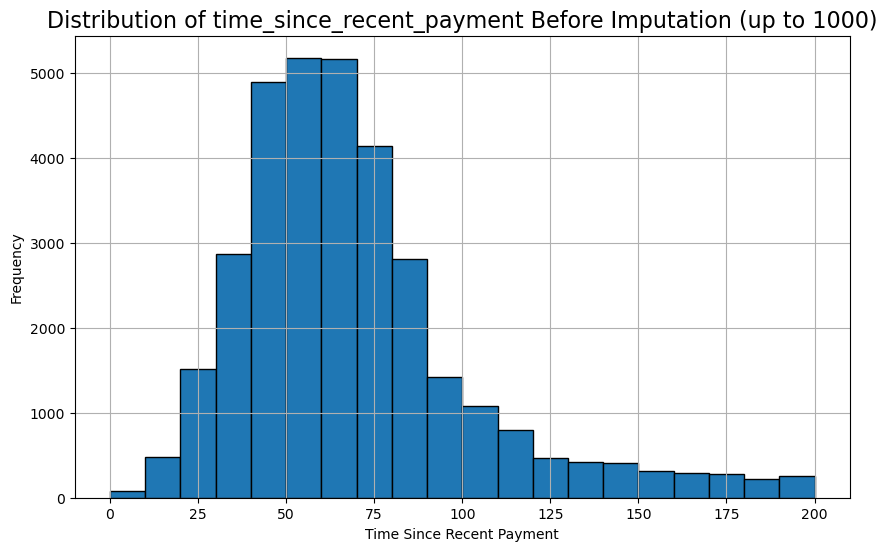

In [25]:
#visualizing for imputation
df['time_since_recent_payment'].describe()

plt.figure(figsize=(10, 6))
df['time_since_recent_payment'].dropna().hist(bins=20, range=(0, 200), edgecolor='black')
plt.title('Distribution of time_since_recent_payment Before Imputation (up to 1000)', fontsize=16)
plt.xlabel('Time Since Recent Payment')
plt.ylabel('Frequency')
plt.show()

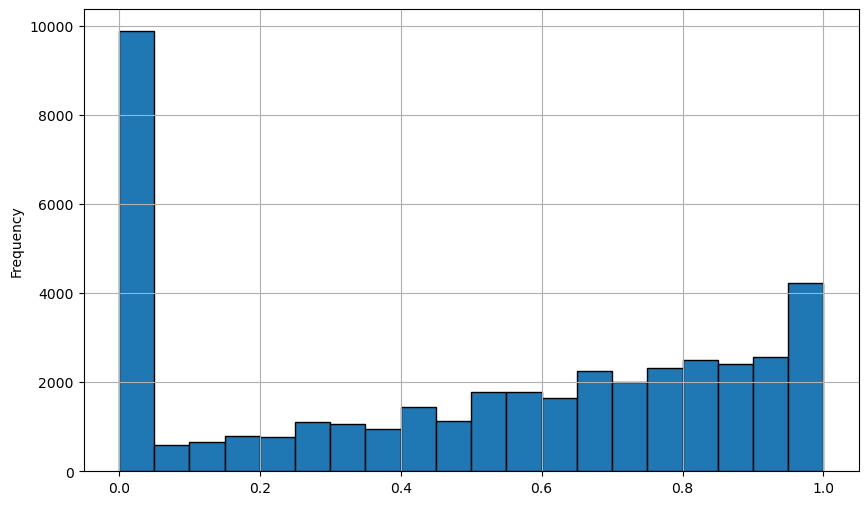

In [26]:
df['pct_currentBal_all_TL'].describe()

plt.figure(figsize=(10, 6))
df['pct_currentBal_all_TL'].dropna().hist(bins=20, range=(0, 1), edgecolor='black')
plt.ylabel('Frequency')
plt.show()

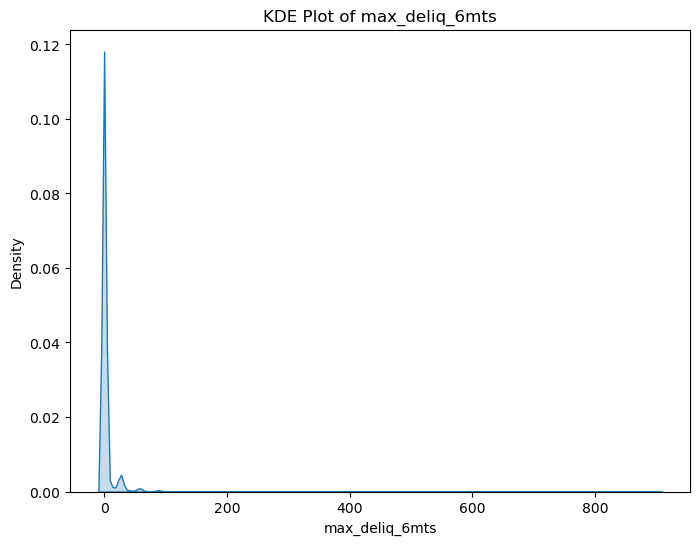

In [27]:
df['max_deliq_6mts'].describe()
plt.figure(figsize=(8, 6))
sns.kdeplot(df['max_deliq_6mts'].dropna(), fill =True)
plt.title('KDE Plot of max_deliq_6mts')
plt.xlabel('max_deliq_6mts')
plt.ylabel('Density')
plt.show()



In [28]:
#finding categorical columns 
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


In [29]:
#running chisquare test for categorical columns - 
columns_to_test = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']

# Perform chi-squared test for each column and the 'Approved_Flag'
for col in columns_to_test:
    contingency_table = pd.crosstab(df[col], df['Approved_Flag'])
    _, p_value, _, _ = chi2_contingency(contingency_table)
    print(f'{col} --- {p_value}')


#all the categorical features have p value less than 0.05 and we accept all . 


MARITALSTATUS --- 1.8488675480840443e-244
EDUCATION --- 1.4046535546725437e-31
GENDER --- 2.246456579867408e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 1.9006158203375562e-287


In [30]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Approved_Flag']), df['Approved_Flag'], test_size=0.2, random_state=42)

In [31]:
#imputing missing values 
#mode imputation for pct_current_Bal
mode_value = X_train['pct_currentBal_all_TL'].mode()[0]
X_train.loc[:, 'pct_currentBal_all_TL'] = X_train['pct_currentBal_all_TL'].fillna(mode_value)
X_test.loc[:, 'pct_currentBal_all_TL'] = X_test['pct_currentBal_all_TL'].fillna(mode_value)

#random imputation for time_since_recent_payment
X_train['time_since_recent_payment_imp'] = X_train['time_since_recent_payment']
X_test['time_since_recent_payment_imp'] = X_test['time_since_recent_payment']
X_train['time_since_recent_payment_imp'][X_train['time_since_recent_payment_imp'].isnull()] = X_train['time_since_recent_payment'].dropna().sample(X_train['time_since_recent_payment'].isnull().sum()).values
X_test['time_since_recent_payment_imp'][X_test['time_since_recent_payment_imp'].isnull()] = X_train['time_since_recent_payment'].dropna().sample(X_test['time_since_recent_payment'].isnull().sum()).values

X_train.drop(columns=['time_since_recent_payment'], inplace=True)
X_test.drop(columns=['time_since_recent_payment'], inplace=True)
X_train.rename(columns={'time_since_recent_payment_imp': 'time_since_recent_payment'}, inplace=True)
X_test.rename(columns={'time_since_recent_payment_imp': 'time_since_recent_payment'}, inplace=True)


num_cols = [col for col in df.columns if df[col].dtype != 'object' and col not in ['PROSPECTID', 'Approved_Flag']]
#iterative imputation max_deliq_6mts and max_deliq_12_mts
imputer = IterativeImputer(random_state=42)
X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])


/var/folders/8r/lp807dgx5l1g14nqdf2kk0_m0000gn/T/ipykernel_20096/2697995436.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['time_since_recent_payment_imp'][X_train['time_since_recent_payment_imp'].isnull()] = X_train['time_sinc

In [32]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

0
0


In [33]:
#using vif on numerical columns for feature selection


vif_subset = X_train[num_cols]
remaining_columns = []
column_index = 0
for i in range (0,vif_subset.shape[1]):

    vif_value = variance_inflation_factor(vif_subset, column_index)
    print (column_index,'---',vif_value)


    if vif_value <= 5:
        remaining_columns.append(num_cols[i])
        column_index = column_index+1

    else:
        vif_subset = vif_subset.drop([ num_cols[i] ] , axis=1)

print("Final set of numeric columns:", remaining_columns)


0 --- 2.1436545932702122
1 --- 7.7551291331125
1 --- 5.362578102304726
1 --- inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


1 --- 8.446372976482998
1 --- 1.6566415774672962
2 --- 3.4423320665219963
3 --- 4.906884580277032
4 --- 7.892057011052673
4 --- 1.5573933036286873
5 --- 6.309958361863844
5 --- 13.897352545084637
5 --- 2.2565381359673027
6 --- 1.4391672963288231
7 --- 2.204726412794737
8 --- 2.6318853534916045
9 --- 2.0103547516757154
10 --- 7.839525618568826
10 --- 1.9445047075855277
11 --- 3.1307117797572723
12 --- 7.015059260475941
12 --- 3.112887214883783
13 --- 1.9454355545863535
14 --- 11.814734244340176
14 --- 6.017194415289826
14 --- 8.54023514613228
14 --- 2.263613888145971
15 --- 7.019388140517744
15 --- 11.401417270888897
15 --- 3.0564250059352744
16 --- 1.5784171558599474
17 --- 12.872218127612069
17 --- 7.945534596926422
17 --- 3.1666235844363833
18 --- 1.4114340227101356
19 --- 1.04666192486203
20 --- 1.2676232945105024
21 --- inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


21 --- 5.345610970359231
21 --- 1.0021078422280842
22 --- 2.7279887752513816
23 --- 2.284069433681566
24 --- 16.18626601227866
24 --- 15.195300089675243
24 --- 1.5512535166212074
25 --- 1.4518269686136687
26 --- 1.7740455490491693
27 --- 4.290506732983012
28 --- 5.631356378671969
28 --- inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


28 --- inf
28 --- 10.92421122977664
28 --- 6.762847052556236
28 --- 6.47893991366947
28 --- 1.7559810646265002
29 --- 2.6017386986497457
30 --- 13.876041722719323
30 --- 6.824361490277871
30 --- 7.164620897145253
30 --- 3.7009284949303245
31 --- 3.944218715748575
32 --- 4.217783974019849
33 --- 1.946010603207944
34 --- inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


34 --- 3.722647806535459
35 --- 21.79370998628337
35 --- 22.295717301710347
35 --- 4.554377528430795
36 --- 2.706412946399727
37 --- 2.601736132297802
38 --- 3.6800088814256746
39 --- 2.0630825695222557
40 --- 4.360245677253152
41 --- 3.879969212364184
Final set of numeric columns: ['time_since_recent_payment', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'num_times_60p_dpd', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_12mts', 'num_lss', 'num_lss_12mts', 'recent_level_of_deliq', 'CC_enq_L12m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L3m', 'AGE', 'NETMONTHLYINCOME', 'Time_With_Curr_Empr', 'pct_currentBal_all_TL', 'CC_Flag', 'PL_Flag', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'HL_Flag', 'GL_Flag', 'pct_tl_open_L6M', 'pct_tl_closed_L6M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'CC_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL']


In [34]:
# now checking for anova values to see which columns to keep - since output column is categorical and input column are continuous
from sklearn.feature_selection import f_classif

f_values, p_values = f_classif(vif_subset, y_train)

anova_results = pd.DataFrame({
    'Feature': vif_subset.columns,  
    'F-Value': f_values, 
    'P-Value': p_values
})

# Filter features based on a p-value threshold 
significant_features = anova_results[anova_results['P-Value'] < 0.05]
features_to_keep = significant_features['Feature'].tolist()

print("Significant Features:", features_to_keep)
len(features_to_keep)

Significant Features: ['time_since_recent_payment', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'num_times_60p_dpd', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_lss', 'recent_level_of_deliq', 'CC_enq_L12m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L3m', 'AGE', 'NETMONTHLYINCOME', 'Time_With_Curr_Empr', 'CC_Flag', 'PL_Flag', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'HL_Flag', 'GL_Flag', 'pct_tl_open_L6M', 'pct_tl_closed_L6M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'CC_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL']


39

In [35]:
cat_cols = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
final_columns_to_keep = features_to_keep + cat_cols

# Subset X_train and X_test with the selected columns
X_train = X_train[final_columns_to_keep]
X_test = X_test[final_columns_to_keep]

print(X_train.shape)
print(X_test.shape)

(35992, 44)
(8998, 44)


In [36]:
#label encoding education

X_train['EDUCATION'] = X_train['EDUCATION'].replace({
    'SSC': 1,
    '12TH': 2,
    'GRADUATE': 3,
    'UNDER GRADUATE': 3,
    'POST-GRADUATE': 4,
    'OTHERS': 1,
    'PROFESSIONAL': 3
})

X_test['EDUCATION'] = X_test['EDUCATION'].replace({
    'SSC': 1,
    '12TH': 2,
    'GRADUATE': 3,
    'UNDER GRADUATE': 3,
    'POST-GRADUATE': 4,
    'OTHERS': 1,
    'PROFESSIONAL': 3
})

/var/folders/8r/lp807dgx5l1g14nqdf2kk0_m0000gn/T/ipykernel_20096/3709345149.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['EDUCATION'] = X_train['EDUCATION'].replace({
/var/folders/8r/lp807dgx5l1g14nqdf2kk0_m0000gn/T/ipykernel_20096/3709345149.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['EDUCATION'] = X_test['EDUCATION'].replace({


In [37]:
#one hot encoding categorical features
X_train = pd.get_dummies(X_train, columns=['MARITALSTATUS', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['MARITALSTATUS', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'], drop_first=True)

In [38]:
#standard scaling 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [39]:
#Label Encode dependent variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [40]:
#model fitting - version 0 
# 1. Logistic Regression
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
logreg_classifier.fit(X_train, y_train)
y_pred_logreg = logreg_classifier.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Accuracy: {accuracy_logreg}\n')

# 2. Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}\n')

# 3. Random Forest
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}\n')

# 4. XGBoost
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class = 4, n_estimators=200, random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb}\n')

# Precision, Recall, F1-score for Logistic Regression, Decision Tree, Random Forest, and XGBoost
models = {
    'Logistic Regression': y_pred_logreg, 
    'Decision Tree': y_pred_dt, 
    'Random Forest': y_pred_rf, 
    'XGBoost': y_pred_xgb
}

for model_name, y_pred in models.items():
    print(f"\nResults for {model_name}:")
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
    
    for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
        print(f"Class {v}:")
        print(f"Precision: {precision[i]}")
        print(f"Recall: {recall[i]}")
        print(f"F1 Score: {f1_score[i]}\n")

Logistic Regression Accuracy: 0.7540564569904423

Decision Tree Accuracy: 0.7142698377417204

Random Forest Accuracy: 0.769059791064681

XGBoost Accuracy: 0.7780617915092243


Results for Logistic Regression:
Class p1:
Precision: 0.8337182448036952
Recall: 0.7169811320754716
F1 Score: 0.7709556860651361

Class p2:
Precision: 0.773400519163231
Recall: 0.9410999628390933
F1 Score: 0.8490486966725337

Class p3:
Precision: 0.41317365269461076
Recall: 0.148068669527897
F1 Score: 0.21800947867298578

Class p4:
Precision: 0.7310536044362292
Recall: 0.653179190751445
F1 Score: 0.6899258613170519


Results for Decision Tree:
Class p1:
Precision: 0.7325933400605449
Recall: 0.7209533267130089
F1 Score: 0.7267267267267268

Class p2:
Precision: 0.815755329008341
Recall: 0.8177257525083612
F1 Score: 0.8167393523243945

Class p3:
Precision: 0.34665747760165405
Recall: 0.3597997138769671
F1 Score: 0.35310635310635313

Class p4:
Precision: 0.6864771748492678
Recall: 0.6581337737407101
F1 Score: 0.67200

In [41]:
#since XGBoost performs well will proceed with futher engineering
#accruacy will not be used in imbalanced dataset - accuracy 
#recall in confusion matrix is taken out for each variable and much more important in imbalanced dataset 
#but recall can be manipulated too so we go with F1 score 

In [42]:
#checking for class imbalance 
df['Approved_Flag'].value_counts()
#P2 is quite high

Approved_Flag
P2    27210
P3     7062
P4     5722
P1     4996
Name: count, dtype: int64

In [43]:
#rmse is scale dependent- if scale is too high and rmse value is small then its good model , for low scale its bad to have same rmse as the one before 
#mape is scale independent its in percentage , but if divided by zero can't find out MAPE

In [44]:
#hyperparameter tuning -
from sklearn.model_selection import GridSearchCV
param_grid = {
    'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 8, 10],
    'alpha': [1, 10, 100],
    'n_estimators': [10, 50, 100]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")



Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Best hyperparameters: {'alpha': 1, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [45]:
# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.01%


In [46]:
class_report = classification_report(y_test, y_pred, target_names=['Class p1', 'Class p2', 'Class p3', 'Class p4'], output_dict=True)

# Output the results for each class
for class_name, metrics in class_report.items():
    if isinstance(metrics, dict): 
        print(f"\nResults for {class_name}:")
        print(f"Precision: {metrics['precision']}")
        print(f"Recall: {metrics['recall']}")
        print(f"F1 Score: {metrics['f1-score']}")


Results for Class p1:
Precision: 0.8284789644012945
Recall: 0.76266137040715
F1 Score: 0.7942088934850051

Results for Class p2:
Precision: 0.8164030653839882
Recall: 0.9303232998885173
F1 Score: 0.8696482848458532

Results for Class p3:
Precision: 0.44802867383512546
Recall: 0.26824034334763946
F1 Score: 0.33557046979865773

Results for Class p4:
Precision: 0.7892824704813806
Recall: 0.717588769611891
F1 Score: 0.7517301038062284

Results for macro avg:
Precision: 0.7205482935254471
Recall: 0.6697034458137994
F1 Score: 0.6877894379839361

Results for weighted avg:
Precision: 0.7568709460794826
Recall: 0.7800622360524561
F1 Score: 0.7623569790250776
